<a href="https://colab.research.google.com/github/lcjln/Kaggle_Project/blob/main/Titanic_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#기본 패키지
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
#plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import tensorflow as tf
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [2]:
#로컬 파일 가져오기
from google.colab import files

uploaded = files.upload()

Saving gender_submission.csv to gender_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


## 1. 데이터 탐색(EDA)

In [3]:
#데이터 파일 가져오기
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()
#test_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


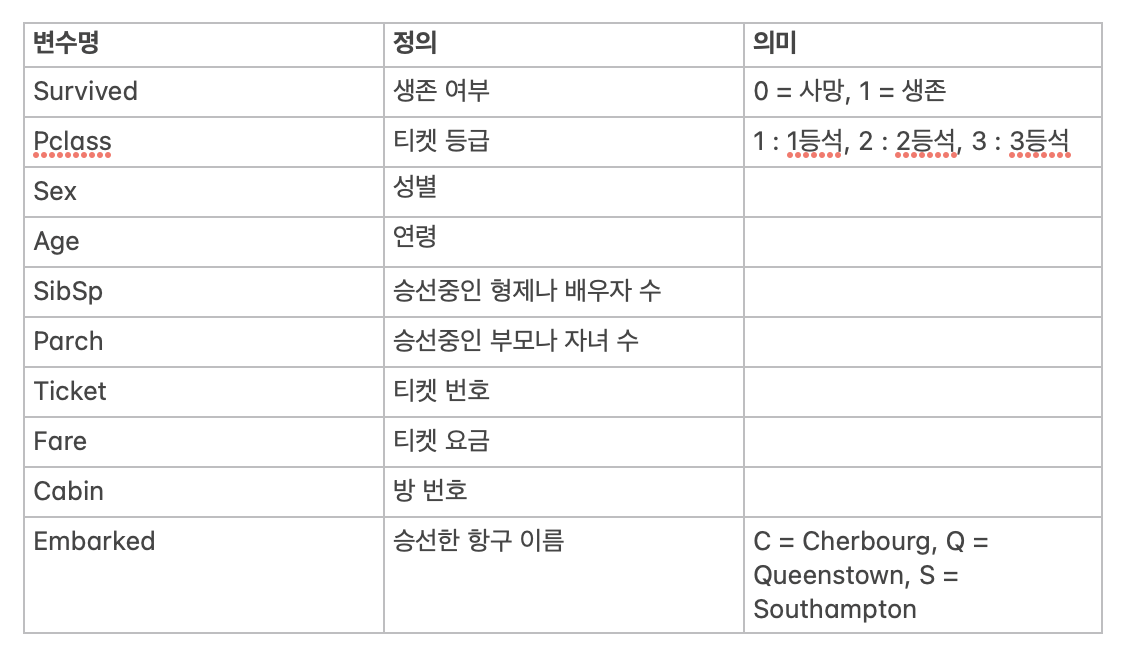

불러온 데이터를 보고 생존(Survive)과 연관 있는 변수는 무엇일까 생각해본다

아마 성별(Sex), 나이(Age), 탑승한 항구(Embarked), 티켓 등급(Pclass)가 생존 여부에 영향을 주는 변수가 아닐까 생각해보며

이 데이터를 중점으로 분석하는 것으로 방향을 잡는다

In [4]:
# 데이터 행과 열 개수 파악하기
print(train_df.shape)
print(test_df.shape)

(891, 12)
(418, 11)


In [5]:
#결측치 확인하기
train_df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


중요 변수라고 생각되는 나이 변수에 상당히 많은 결측치가 발견되었다.

이를 어떻게 대채할지 생각해봐야할 듯하다

# 목적 변수 데이터 시각화

승선한 항구(Embarked)와 생존 여부(Survived)에 대해 시각화를 진행

In [6]:
train_df[['Embarked','Survived','PassengerId']]

,Embarked,Survived,PassengerId
0,S,0,1
1,C,1,2
2,S,1,3
3,S,1,4
4,S,0,5
...,...,...,...
886,S,0,887
887,S,1,888
888,S,0,889
889,C,1,890


In [7]:
train_df[['Embarked','Survived','PassengerId']].dropna()

,Embarked,Survived,PassengerId
0,S,0,1
1,C,1,2
2,S,1,3
3,S,1,4
4,S,0,5
...,...,...,...
886,S,0,887
887,S,1,888
888,S,0,889
889,C,1,890


Embarked와 Survived 집계하기

In [8]:
embarked_df = train_df[['Embarked','Survived','PassengerId']].dropna().groupby(['Embarked','Survived']).count().unstack()
embarked_df

PassengerId     
Survived           0    1
Embarked                 
C                 75   93
Q                 47   30
S                427  217

<Axes: xlabel='Embarked'>

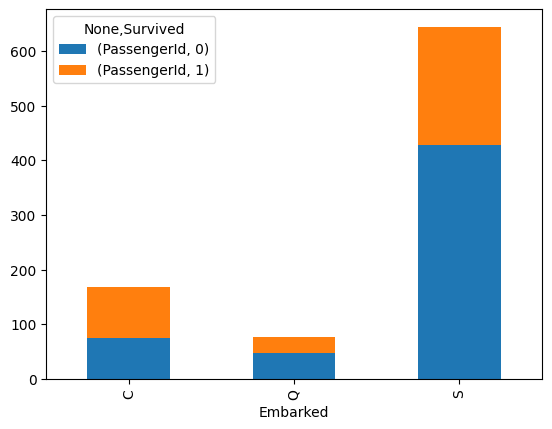

In [9]:
embarked_df.plot.bar(stacked=True)

승선 항구가 C일 때 절반 정도 생존했지만 나머지 Q, S의 경우 절반 이상이 사망했음을 알 수 있다

-> 어쩌면 승선 항구에 따라 승객 유형이나 상태에 차이가 있는 등 생존 여부에 영향을 주는 요인이 될 수 있음

시각화를 통해 알아낸 정보를 더 자세히 알기 위해 생존율(수치)를 직접 구해본다

In [10]:
embarked_df['survived_rate'] = embarked_df.iloc[:,1] / (embarked_df.iloc[:,0] + embarked_df.iloc[:,1])
embarked_df

PassengerId      survived_rate
Survived           0    1              
Embarked                               
C                 75   93      0.553571
Q                 47   30      0.389610
S                427  217      0.336957

성별과 티켓 등급 시각화하기

<Axes: xlabel='Sex'>

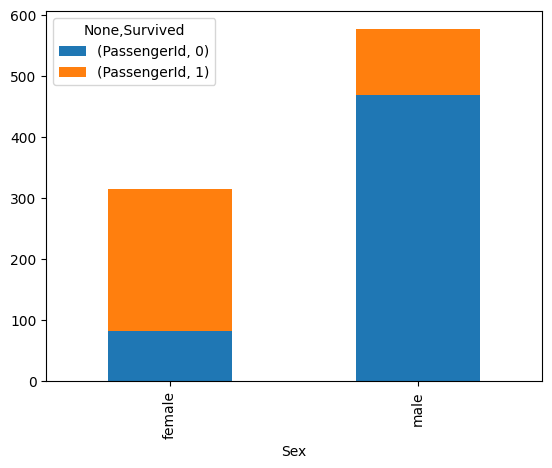

In [11]:
sex_df = train_df[['Sex','Survived','PassengerId']].dropna().groupby(['Sex','Survived']).count().unstack()
sex_df.plot.bar(stacked=True)

<Axes: xlabel='Pclass'>

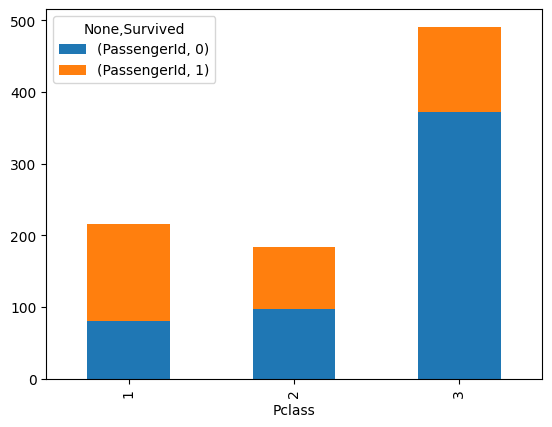

In [12]:
ticket_df = train_df[['Pclass','Survived','PassengerId']].dropna().groupby(['Pclass','Survived']).count().unstack()
ticket_df.plot.bar(stacked=True)

연령별 생존율을 시각화하여 확인한다. 나이는 연속형 변수이므로 히스토그램을 만들어 확인한다.

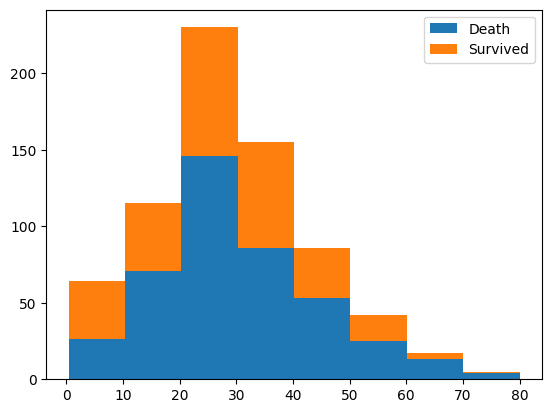

In [13]:
plt.hist(x = [train_df[train_df['Survived']==0]['Age'],train_df[train_df['Survived']==1]['Age']],
         bins = 8,
         histtype = 'barstacked',
         label = ['Death', 'Survived'])
plt.legend()

목적 변수들간의 상관계수를 구한다. 그러기 위해 명목형 변수들은 더미변수를 만들어 숫자형 변수로 만든다

In [14]:
train_df_corr = pd.get_dummies(train_df, columns = ['Sex'], drop_first = True, dtype = int) # dtype = 1 은 T/F를 1/0으로 변환
train_df_corr = pd.get_dummies(train_df, columns = ['Embarked'], dtype = int)
train_df_corr

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,1,0,0


In [16]:
train_corr = train_df_corr.select_dtypes(include = 'number').corr()
train_corr

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,-0.001205,-0.033606,0.022148
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.168240,0.003650,-0.155660
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.243292,0.221009,0.081720
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.036261,-0.022405,-0.032523
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.059528,-0.026354,0.070941
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.011069,-0.081228,0.063036
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.269335,-0.117216,-0.166603
Embarked_C,-0.001205,0.168240,-0.243292,0.036261,-0.059528,-0.011069,0.269335,1.000000,-0.148258,-0.778359
Embarked_Q,-0.033606,0.003650,0.221009,-0.022405,-0.026354,-0.081228,-0.117216,-0.148258,1.000000,-0.496624
Embarked_S,0.022148,-0.155660,0.081720,-0.032523,0.070941,0.063036,-0.166603,-0.778359,-0.496624,1.000000


<Axes: >

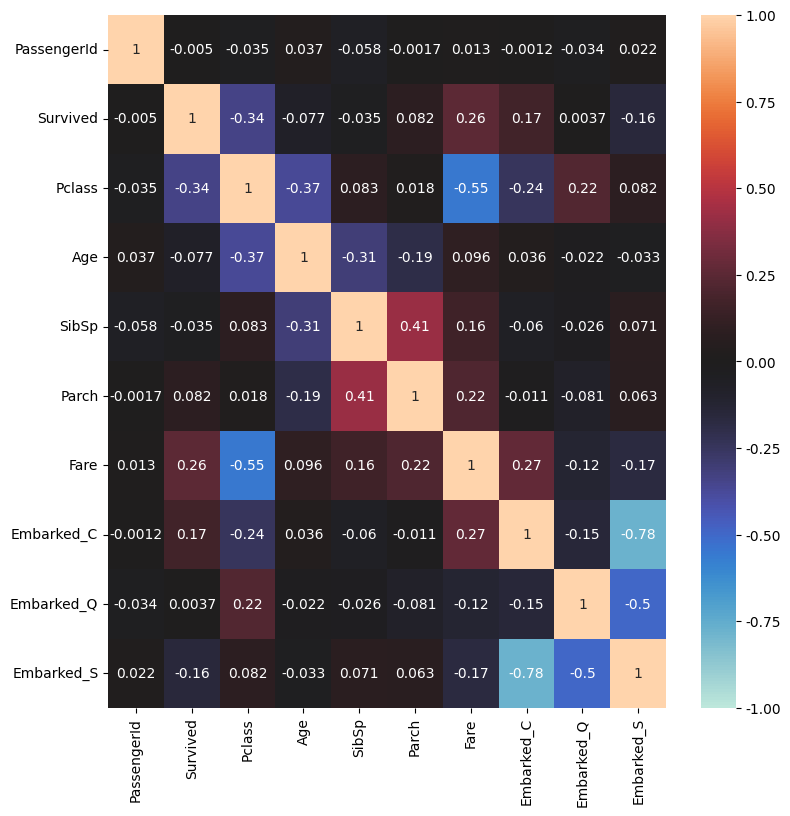

In [17]:
plt.figure(figsize=(9,9))
sns.heatmap(train_corr,
           vmax = 1,
           vmin = -1,
           center = 0,
           annot = True)